<a href="https://colab.research.google.com/github/vanigupta123/nbody_sim/blob/main/nbody_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
%%writefile main.cu
#include <stdio.h>
#include <curand_kernel.h>
#include <cuda_runtime.h>
#include <math.h>
#include <ftw.h>
#include <fstream>

__global__ void initParticles(int N, float4 *pos, float4 *vel, float4 *acc) {
  // this is a kernel and will be called with params<<<grid_dimensions, block_dimensions>>>
  int idx = (blockIdx.x * blockDim.x) + threadIdx.x;
  // printf("%d\n", idx);
  if (idx >= N) return;

  curandState state;
  curand_init(1234ULL, idx, 0, &state);

  float4 p;
  p.x = 100.0f * curand_uniform(&state) - 50.0f;
  p.y = 100.0f * curand_uniform(&state) - 50.0f;
  p.z = 100.0f * curand_uniform(&state) - 50.0f;
  p.w = 10.0f + 40.0f * curand_uniform(&state);
  pos[idx] = p;
  vel[idx] = {0.0f, 0.0f, 0.0f, 0.0f};
  acc[idx] = {0.0f, 0.0f, 0.0f, 0.0f};
}

__device__ float3 getAcceleration(float4 &pos_i, float4 &pos_j, float3 &acc) {
  const float EPS2 = 1.0f/150.0f;
  // F = Gm1m2/|r|^2 * r/|r|
  // a1 = Gm2r/|r|^3
  // with softening -> a1 = Gm2r/(|r|^2 + eps^2)^(3/2)
  float3 r;
  float magSquared, val;
  // all threads in a block have access to the same shared memory
  // one shared memory per block
  // must synchronize threads to prevent race condition
    // thread can only continue execution once all threads in block have synchronized
    // must have synchronization at same point for each thread or else the code will deadlock
  r.x = pos_j.x - pos_i.x;
  r.y = pos_j.y - pos_i.y;
  r.z = pos_j.z - pos_i.z;
  magSquared = (r.x*r.x) + (r.y*r.y) + (r.z*r.z) + EPS2;
  val = pos_j.w * rsqrt(magSquared * magSquared * magSquared);
  acc.x += r.x * val;
  acc.y += r.y * val;
  acc.z += r.z * val;
  return acc;
}

__device__ float3 tileCalculation(float4 pos_i, float3 accel, int valid) {
  int i;
  extern __shared__ float4 shPosition[];
  for (i = 0; i < valid; i++) {
    accel = getAcceleration(pos_i, shPosition[i], accel);
  }
  return accel;
}

__global__ void calculateForces(int N, float4 *devA, float4 *devX) {
  extern __shared__ float4 shPosition[]; // var declaration in shared memory
  int gtid = blockIdx.x * blockDim.x + threadIdx.x;
  if (gtid >= N) return;
  // float G = 6.6743e-11; // can't use for sim purposes. won't show any movement
  float G = 1.0f;
  float3 acc = {0.0f, 0.0f, 0.0f};
  float4 pos_i = devX[gtid];
  // tiles are pxp, where p = blockDim.x
  for (int i = 0, tile = 0; i < N; i += blockDim.x, tile++) {
    int idx = tile * blockDim.x + threadIdx.x;
    if (idx < N) shPosition[threadIdx.x] = devX[idx];
    // guards load for last partial tile. remaining threads otherwise have invalid devX[idx] vals
    __syncthreads();
    int valid = min(blockDim.x, N-tile);
    acc = tileCalculation(pos_i, acc, valid);
    __syncthreads();
  }
  float4 acc4 = {G*acc.x, G*acc.y, G*acc.z, 0.0f}; // for global acceleration var
  devA[gtid] = acc4;
}

__global__ void verletIntegration(int N, float4 *acc, float4 *pos, float4 *vel, float dt) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  if (idx >= N) return;
  float4 a = acc[idx];
  float4 p = pos[idx];
  float4 v = vel[idx];

  // position = x_0 + v dt + (1/2) a dt^2
  p.x += (v.x * dt) + (0.5f * a.x * dt * dt);
  p.y += (v.y * dt) + (0.5f * a.y * dt * dt);
  p.z += (v.z * dt) + (0.5f * a.z * dt * dt);

  // half step of velocity = v_0 + (1/2) a * dt
  v.x += 0.5f * a.x * dt;
  v.y += 0.5f * a.y * dt;
  v.z += 0.5f * a.z * dt;

  pos[idx] = p;
  vel[idx] = v;
}

__global__ void verletIntegration2(int N, float4 *acc, float4 *vel, float dt) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  if (idx >= N) return;

  float4 a = acc[idx];
  float4 v = vel[idx];
  // second half step of velocity after updated acc
  v.x += 0.5f * a.x * dt;
  v.y += 0.5f * a.y * dt;
  v.z += 0.5f * a.z * dt;

  vel[idx] = v;
}

int unlink_cb(const char *fpath, const struct stat *sb, int typeflag, struct FTW *ftwbuf) {
  int rv = remove(fpath);
  if (rv) perror(fpath);
  return rv;
}

int main() {
  printf("hello from colab GPU!\n");
  int N = 1000;
  float4 *d_pos, *d_vel, *d_acc;
  cudaMalloc(&d_pos, N*sizeof(float4));
  cudaMalloc(&d_vel, N*sizeof(float4));
  cudaMalloc(&d_acc, N*sizeof(float4));

  // one thread per particle
  int blockSize = 256;
  int numBlocks = (N + blockSize - 1)/blockSize; // same as ceil(N/blockSize)
  initParticles<<<numBlocks, blockSize>>>(N, d_pos, d_vel, d_acc);
  int shareMem = sizeof(float4) * blockSize;
  int numSteps = 1000;
  const char *path = "/content/output/";
  nftw(path, unlink_cb, 64, FTW_DEPTH|FTW_PHYS);
  mkdir(path, S_IRWXU);
  for (int step = 0; step < numSteps; step++) {
    verletIntegration<<<numBlocks, blockSize>>>(N, d_acc, d_pos, d_vel, 0.05f);
    calculateForces<<<numBlocks, blockSize, shareMem>>>(N, d_acc, d_pos);
    verletIntegration2<<<numBlocks, blockSize>>>(N, d_acc, d_vel, 0.05f);
    // float4 t_pos[1];
    // cudaMemcpy(t_pos, d_pos, sizeof(float4), cudaMemcpyDeviceToHost);
    // printf("pos is (%.2f, %.2f, %.2f)\n", t_pos[2].x, t_pos[2].y, t_pos[2].z);
    if (step % 10 == 0) {
      // record position with a particle id
      float4 h_pos[N];
      cudaMemcpy(h_pos, d_pos, N*sizeof(float4), cudaMemcpyDeviceToHost);
      std::ofstream file("output/output_" + std::to_string(step) + ".csv");
      file << "id,x,y,z,m\n";
      for (int i = 0; i < N; i++) {
        file << i << "," << h_pos[i].x << "," << h_pos[i].y << "," << h_pos[i].z << "," << h_pos[i].w << "\n";
      }
      file.close();
    }
  }
  cudaError_t err = cudaGetLastError();
  if (err != cudaSuccess) {
    printf("CUDA error: %s\n", cudaGetErrorString(err));
  }
  cudaDeviceSynchronize();

  // sample of initial velocities and positions
  float4 s_pos[5], s_vel[5], s_acc[5]; // for 5 particles
  cudaMemcpy(s_pos, d_pos, 5*sizeof(float4), cudaMemcpyDeviceToHost);
  cudaMemcpy(s_vel, d_vel, 5*sizeof(float4), cudaMemcpyDeviceToHost);
  cudaMemcpy(s_acc, d_acc, 5*sizeof(float4), cudaMemcpyDeviceToHost);

  for (int i = 0; i < 5; i++) {
    printf("particle with mass %.4f at position (%.2f, %.2f, %.2f) with velocity (%.3e, %.3e, %.3e) and net acc of (%.3e, %.3e, %.3e)\n",
    s_pos[i].w, s_pos[i].x, s_pos[i].y, s_pos[i].z,
    s_vel[i].x, s_vel[i].y, s_vel[i].z,
    s_acc[i].x, s_acc[i].y, s_acc[i].z
    );
  }

  return 0;
}

Overwriting main.cu


In [31]:
!nvcc -arch=sm_75 main.cu -o main

In [32]:
!./main

hello from colab GPU!
particle with mass 28.2066 at position (10.01, -5.15, -23.05) with velocity (-5.230e+00, 1.920e+01, -1.059e+01) and net acc of (-1.261e+00, 2.570e+00, 4.758e+00)
particle with mass 31.5037 at position (54.22, -6.38, 21.85) with velocity (-6.104e+00, 1.079e+01, -9.547e+00) and net acc of (-4.560e+00, 4.469e-01, -1.912e+00)
particle with mass 39.7015 at position (-314.65, 1182.41, -2618.74) with velocity (-6.477e+00, 2.316e+01, -5.357e+01) and net acc of (2.596e-04, -1.428e-03, 3.030e-03)
particle with mass 31.4242 at position (446.11, 8.02, -237.91) with velocity (3.662e+00, -4.064e-01, -1.569e+00) and net acc of (-8.816e-01, 8.976e-01, 1.101e+00)
particle with mass 12.3345 at position (1837.69, -1497.91, -1784.67) with velocity (3.606e+01, -3.028e+01, -3.604e+01) and net acc of (-2.184e-03, 1.639e-03, 1.940e-03)


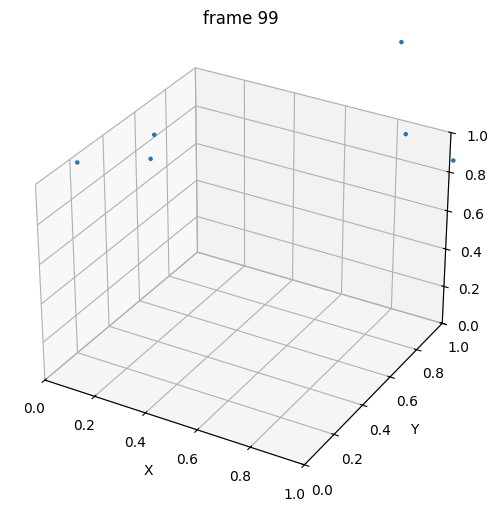

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import glob

files = sorted(glob.glob("/content/output/output_*.csv"), key=lambda x: int(x.split('_')[1].split('.')[0]))
frames = [pd.read_csv(file) for file in files]
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter([], [], [], s=2)

def init():
  ax.set_xlim(0,1)
  ax.set_ylim(0,1)
  ax.set_zlim(0,1)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  return sc,

def update(frame_idx):
  data = frames[frame_idx]
  ax.clear() # clears previous points
  ax.set_xlim(-50, 50)
  ax.set_ylim(-50, 50)
  ax.set_zlim(-50, 50)
  ax.set_title(f"frame {frame_idx}")
  ax.scatter(data['x'], data['y'], data['z'], s=5)
  return ax,

animation = FuncAnimation(fig, update, frames=len(frames), init_func=init,
                          interval=50, blit=False, repeat=False)
animation.save('nbody_sim.mp4', writer='ffmpeg', fps=30)
